# Working with Cloud Optimized NASA Earth Science Data

#### *Author: Ed Armstrong, PO.DAAC*

*Reference herein to any specific commercial product, process, or service by trade name, trademark, manufacturer, or otherwise, does not constitute or imply its endorsement by the United States Government or the Jet Propulsion Laboratory, California Institute of Technology.*

## Summary

Lightweight notebook to read, condition and plot various NASA cloud optimized earth science datasets created with virtualizarr or kerchunk


## Import Packages
#### ***Note using Zarr Version 2***

In [1]:
pip install earthaccess>=0.13.0 zarr==2.18.7 fastparquet>=2024.5.0 xarray==2025.4.0 fsspec>=2024.10.0 "dask[complete]">=2024.5.2 h5netcdf==1.3.0 ujson>=5.10.0 matplotlib>=3.9.2  kerchunk==0.2.7 virtualizarr==1.3.2  cftime cartopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip list | grep -E "zarr|xarray|virtualizarr|kerchunk"

kerchunk                  0.2.7
virtualizarr              1.3.2
xarray                    2025.4.0
zarr                      2.18.7
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Built-in packages
import os
import sys

# Filesystem management 
import fsspec
import earthaccess

# Data handling
import xarray as xr
import numpy as np

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client

# Other
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Other Setup

In [4]:
xr.set_options( # display options for xarray objects
    display_expand_attrs=False,
    display_expand_coords=True,
    display_expand_data=True,
)

## 1. Get Data File S3 endpoints in Earthdata Cloud 
The first step is to find the S3 endpoints to the files. Handling access credentials to Earthdata and then finding the endpoints can be done a number of ways (e.g. using the `requests`, `s3fs` packages) but we use the `earthaccess` package for its ease of use. We get the endpoints for all files in the CCMP record.

In [5]:
# Get Earthdata creds
earthaccess.login()

Enter your Earthdata Login username:  edward.m.armstrong
Enter your Earthdata password:  ········


In [22]:
# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
#fs = earthaccess.get_fsspec_https_session() 

## 2. Open reference files from S3 bucket

The reference can be saved to file and used to open the corresponding CCMP data file with Xarray:

In [23]:
# Open data using the reference file, using a small wrapper function around xarray's open_dataset. 
# This will shorten code blocks in other sections. 
def opends_withref(ref, fs_data):
    """
    "ref" is a reference file or object. "fs_data" is a filesystem with credentials to
    access the actual data files. 
    """
    storage_opts = {"fo": ref, "remote_protocol": "s3", "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    m = fs_ref.get_mapper('')
    data = xr.open_dataset(
        m, engine="zarr", chunks={},
        backend_kwargs={"consolidated": False}
    )
    return data

### OSTIA Daily Sea Surface Temperature (OSTIA-UKMO-L4-GLOB-REP-v2.0)

In [24]:
%%time

# Open the OSTIA Reprocessed SST reference file (OSTIA-UKMO-L4-GLOB-REP-v2.0)
sst_ds = opends_withref('https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-docs/ghrsst/open/docs/OSTIA-UKMO-L4-GLOB-REP-v2.0_combined-ref.json', fs)
#sst_ds = opends_withref('https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/OSTIA-UKMO-L4-GLOB-REP-v2.0/OSTIA-UKMO-L4-GLOB-REP-v2.0_virtual.json', fs)
print(sst_ds)
#sst_ds

<xarray.Dataset> Size: 11TB
Dimensions:           (time: 15340, lat: 3600, lon: 7200)
Coordinates:
  * lat               (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon               (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time              (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 202...
Data variables:
    analysed_sst      (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    mask              (time, lat, lon) float32 2TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (39)
CPU times: user 2.6 s, sys: 328 ms, total: 2.92 s
Wall time: 6.84 s


### OSCAR Daily Ocean Surface Currents SST (OSCAR_L4_OC_FINAL_V2.0)

In [ ]:
%%time

# Open the OSCAR  Currents reference file (OSCAR_L4_OC_FINAL_V2.0)
curr_ds = opends_withref('https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-docs/oscar/open/L4/oscar_v2.0/docs/OSCAR_L4_OC_FINAL_V2.0_combined-ref.json', fs)

# set the 'time' to an understandable ISO format
datetimeindex = curr_ds.indexes['time'].to_datetimeindex()
curr_ds['time'] = datetimeindex

# Fix the two NaN values in the lon and lat variables that correspond to 0
curr_ds['lat'][359] = 0.0
curr_ds['lon'][0] = 0.0

print(curr_ds)
curr_ds

### CCMP 6 Hourly Ocean Winds (CCMP_WINDS_10M6HR_L4_V3.1)

In [ ]:
%%time

# Open the CCMP Winds reference file (CCMP_WINDS_10M6HR_L4_V3.1)
wind_ds = opends_withref('https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-docs/ccmp/open/L4_V3.1/docs/CCMP_WINDS_10M6HR_L4_V3.1_combined-ref.json', fs)

print(wind_ds)
#wind_ds

### Data set up and conditioning

In [ ]:
%%time

# Define region
#offshore Monterey Bay, CA as a one degree box 

# Gulf of Tehuantepec, MX
lat_min = 14.
lat_max = 15.
lon_min = -96.
lon_max = -95.

lat_range = (lat_min, lat_max)
lon_range = (lon_min, lon_max)

# for datasets that use 0-360 deg lon
lon_range_360 = (lon_min+360, lon_max+360)

# Define the time slice 
start_date = '1993-01-01'
end_date = '2002-12-31'
time_range =(start_date, end_date)

# Subset the datasets
# OSTIA SST
sst = sst_ds['analysed_sst'].sel(lon=slice(*lon_range), lat=slice(*lat_range), time=slice(*time_range))

# CCMP Wind uses 0-360 deg longitudes
wind_speed = wind_ds['ws'].sel(longitude=slice(*lon_range_360), latitude=slice(*lat_range), time=slice(*time_range))

# OSCAR Current uses 0-360 deg longitudes
#u_curr = curr_ds['u'].sel(longitude=slice(*lon_range_360), latitude=slice(*lat_range), time=slice(*time_range))
#v_curr = curr_ds['v'].sel(longitude=slice(*lon_range_360), latitude=slice(*lat_range), time=slice(*time_range))

# Compute regional means
sst_mean = sst.mean(dim=["lat", "lon"])
wind_speed_mean = wind_speed.mean(dim=["latitude", "longitude"])
#current = np.sqrt(u_curr**2 + v_curr**2)
#current_mean = current.mean(dim=["latitude", "longitude"])

print("sst values ", sst_mean[0:20].values)
print("wind values ", wind_speed_mean[0:20].values)
#print("current values ", current_mean[0:20].values)
print("done w initial data conditioning and subsetting \n")

### Resample the means to a different time scale (e.g., monthly) and load into memory

In [ ]:
%%time

# Execute Tasks: Convert to weekly (1W) monthly (1ME) or annual means (1YE).  
# use load() to load the result into memory in preparation for plotting

sst_resample = sst_mean.resample(time="1ME").mean().load()
wind_speed_resample = wind_speed_mean.resample(time="1ME").mean().load()
#current_resample = current_mean.resample(time="1ME").mean().load()

#print(sst_resample.size, sst_mean.size)
#print(wind_speed_resample.size, wind_speed_mean.size)

### Plot the result

In [ ]:
# Plot set up
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('SST (°K)', color=color)
ax1.plot(sst_resample['time'], sst_resample, linewidth=3, color=color, label='SST')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Wind Speed (m/s)', color=color)
ax2.plot(wind_speed_resample['time'], wind_speed_resample, color=color, label='Wind Speed')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("SST and Ocean Surface Wind Speed ")
plt.show()

### Another method to do the same thing with reduced code

In [ ]:
%%time

# Another method to subset, resample, and average the xarray data all on one line
sst_resample = sst_ds.analysed_sst.sel(lon=slice(*lon_range), lat=slice(*lat_range), time=slice(*time_range)).mean(["lat", "lon"]).resample(time="1ME").mean().load()
wind_speed_resample = wind_ds.ws.sel(longitude=slice(*lon_range_360), latitude=slice(*lat_range), time=slice(*time_range)).mean(["latitude", "longitude"]).resample(time="1ME").mean().load()

### Check with a plot 

In [ ]:
# Check with a plot 
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('SST (°K)', color=color)
ax1.plot(sst_resample['time'], sst_resample, linewidth=3, color=color, label='SST')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Wind Speed (m/s)', color=color)
ax2.plot(wind_speed_resample['time'], wind_speed_resample, color=color, label='Wind Speed')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("SST and Ocean Surface Wind Speed")
plt.show()

### Yet a third way using coarsen() v.s. resample()

In [ ]:
%%time 
# Yet a third method using coarsen()
# Not as systematic as resample()

#set time to the resample (coarsen)  time, e.g., 365 is number of days in a year, 1460 6 hour time steps etc. 
sst_resample = sst_mean.coarsen(time=30, boundary='trim').mean().load()
wind_speed_resample = wind_speed_mean.coarsen(time=180, boundary='trim').mean().load()
#current_resample = current_mean.coarsen(time=365, boundary='trim').mean().load()


### Check with a plot 

In [ ]:
# Check with a plot 
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('SST (°K)', color=color)
ax1.plot(sst_resample['time'], sst_resample, linewidth=3,color=color, label='SST')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Wind Speed (m/s)', color=color)
ax2.plot(wind_speed_resample['time'], wind_speed_resample, color=color, label='Wind Speed')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("SST and Ocean Surface Wind Speed")
plt.show()

### Use parallel processing to speed the resample() approach

In [ ]:
# Set up parallel processing

# Check how many cpu's are on this VM:
print("CPU count =", multiprocessing.cpu_count())

# Start up cluster and print some information about it:
client = Client(n_workers=8, threads_per_worker=1)
print(client.cluster)
print("View any work being done on the cluster here", client.dashboard_link)

In [ ]:
%%time

# Execute Tasks: Convert to weekly (1W) monthly (1ME) or annual means (1YE).  
# use load() to load into memory the result
sst_resample = sst_mean.resample(time="1ME").mean().load()
wind_speed_resample = wind_speed_mean.resample(time="1ME").mean().load()
#current_resample = current_mean.resample(time="1ME").mean()

# Trigger computation with parallel execution....optional
sst_data, wind_speed_data = da.compute(sst_resample, wind_speed_resample)

### Check with a plot 

In [ ]:
# Check with a plot 
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('SST (°K)', color=color)
ax1.plot(sst_resample['time'], sst_resample, linewidth=3,color=color, label='SST')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Wind Speed (m/s)', color=color)
ax2.plot(wind_speed_resample['time'], wind_speed_resample, color=color, label='Wind Speed')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("SST and Ocean Surface Wind Speed")
plt.show()

In [25]:
%%time

# Define spatial region, adjust as needed

# Gulf of Tehuantepec, MX
lat_min = 12.
lat_max = 17.
lon_min = -97.
lon_max = -92.

lat_range = (lat_min, lat_max)
lon_range = (lon_min, lon_max)

# Define the time slice 
start_date = '1982-01-01'
end_date = '2023-12-31'
time_range =(start_date, end_date)

# Subset the datasets
# OSTIA SST
sst_region = sst_ds['analysed_sst'].sel(lon=slice(*lon_range), lat=slice(*lat_range), time=slice(*time_range))

# Select only January time steps using .dt.month == 1
sst_month = sst_region.sel(time=sst_region['time'].dt.month == 1)
print(sst_month)

<xarray.DataArray 'analysed_sst' (time: 1302, lat: 100, lon: 100)> Size: 104MB
dask.array<getitem, shape=(1302, 100, 100), dtype=float64, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 400B 12.02 12.07 12.12 12.18 ... 16.88 16.92 16.98
  * lon      (lon) float32 400B -96.97 -96.93 -96.88 ... -92.12 -92.07 -92.03
  * time     (time) datetime64[ns] 10kB 1982-01-01T12:00:00 ... 2023-01-31T12...
Attributes: (7)
CPU times: user 404 ms, sys: 8.73 ms, total: 412 ms
Wall time: 411 ms


In [27]:
%%time

# calculate and plot the spatial mean and convert to degrees Celsius
sst_month_avg = sst_month.mean(dim='time').compute() - 273.15

#sst_month_avg = sst_month.mean(dim='time').load() - 273.15

CPU times: user 46.1 s, sys: 10.5 s, total: 56.6 s
Wall time: 23.9 s


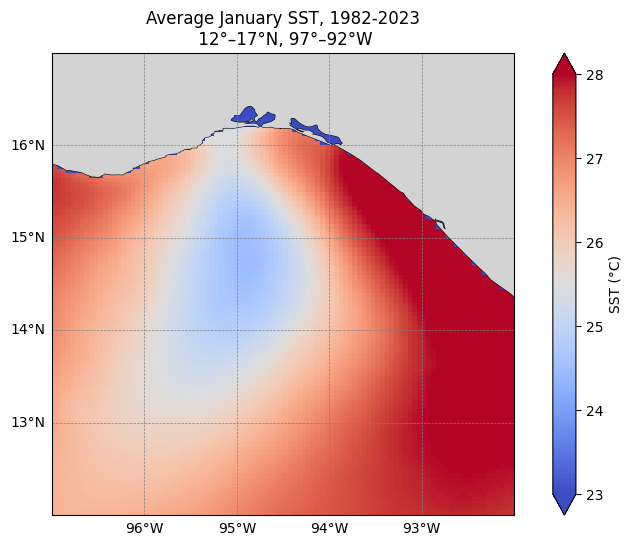

In [14]:
# Create the figure and axes using a PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
sst_month_avg.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    vmin=23, vmax=28,
    cbar_kwargs={'label': 'SST (°C)'}
)

# Add coastlines and land
ax.coastlines(resolution='10m', linewidth=0.8)
#ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':')

from cartopy.feature import NaturalEarthFeature
land_10m = NaturalEarthFeature('physical', 'land', '10m', facecolor='lightgray')
ax.add_feature(land_10m)

# Set the extent of the region
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.title('Average January SST, 1982-2023\n 12°–17°N, 97°–92°W')
plt.show()
